In [1]:
# Projeto integrado da Pós-graduação Lato Sensu em Inteligência Artificial e Aprendizado de Máquina | Junho de 2023
# Aluno: Matheus Bonetto Balbino

In [2]:
#Importando as bibliotecas

#Bibliotecas de manipulação do python
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import tensorflow as tf

#Biblioteca do Keras para construção da rede neural
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


#Biblioteca sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

#Importação da biblioteca para obter os dados
import yfinance as yf

In [3]:
#Importando base de dados total
dataset = yf.download("ABEV3.SA", start='2019-01-02', end='2023-03-31', interval='1d')

#Base de treinamento
dataset_train = yf.download("ABEV3.SA", start='2019-01-02', end='2021-12-22', interval='1d')

#Base de teste
dataset_test = yf.download("ABEV3.SA", start='2021-12-23', end='2023-03-31', interval='1d')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
len(dataset)

1055

In [5]:
len(dataset_train)

737

In [6]:
len(dataset_test)

317

In [7]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,15.400000,16.299999,15.400000,16.150000,13.950426,18692900
2019-01-03,16.010000,16.330000,15.890000,16.330000,14.105910,22739200
2019-01-04,16.299999,16.690001,16.030001,16.549999,14.295947,27484600
2019-01-07,16.570000,16.629999,16.340000,16.480000,14.235480,17084500
2019-01-08,16.540001,16.700001,16.090000,16.150000,13.950426,22108700


In [8]:
dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,15.400000,16.299999,15.400000,16.150000,13.950426,18692900
2019-01-03,16.010000,16.330000,15.890000,16.330000,14.105910,22739200
2019-01-04,16.299999,16.690001,16.030001,16.549999,14.295948,27484600
2019-01-07,16.570000,16.629999,16.340000,16.480000,14.235481,17084500
2019-01-08,16.540001,16.700001,16.090000,16.150000,13.950426,22108700


In [9]:
dataset_test.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-23,15.40,15.67,15.34,15.55,14.771684,10634700
2021-12-27,15.55,15.65,15.48,15.53,14.752684,8437200
2021-12-28,15.54,15.57,15.40,15.52,14.743185,7701300
2021-12-29,15.55,15.56,15.34,15.45,14.676688,8847300
2021-12-30,15.58,15.59,15.39,15.42,14.648190,11819300


In [10]:
dataset.isnull().sum().sum() #Retorna o número que valores que estão faltando no dataset

0

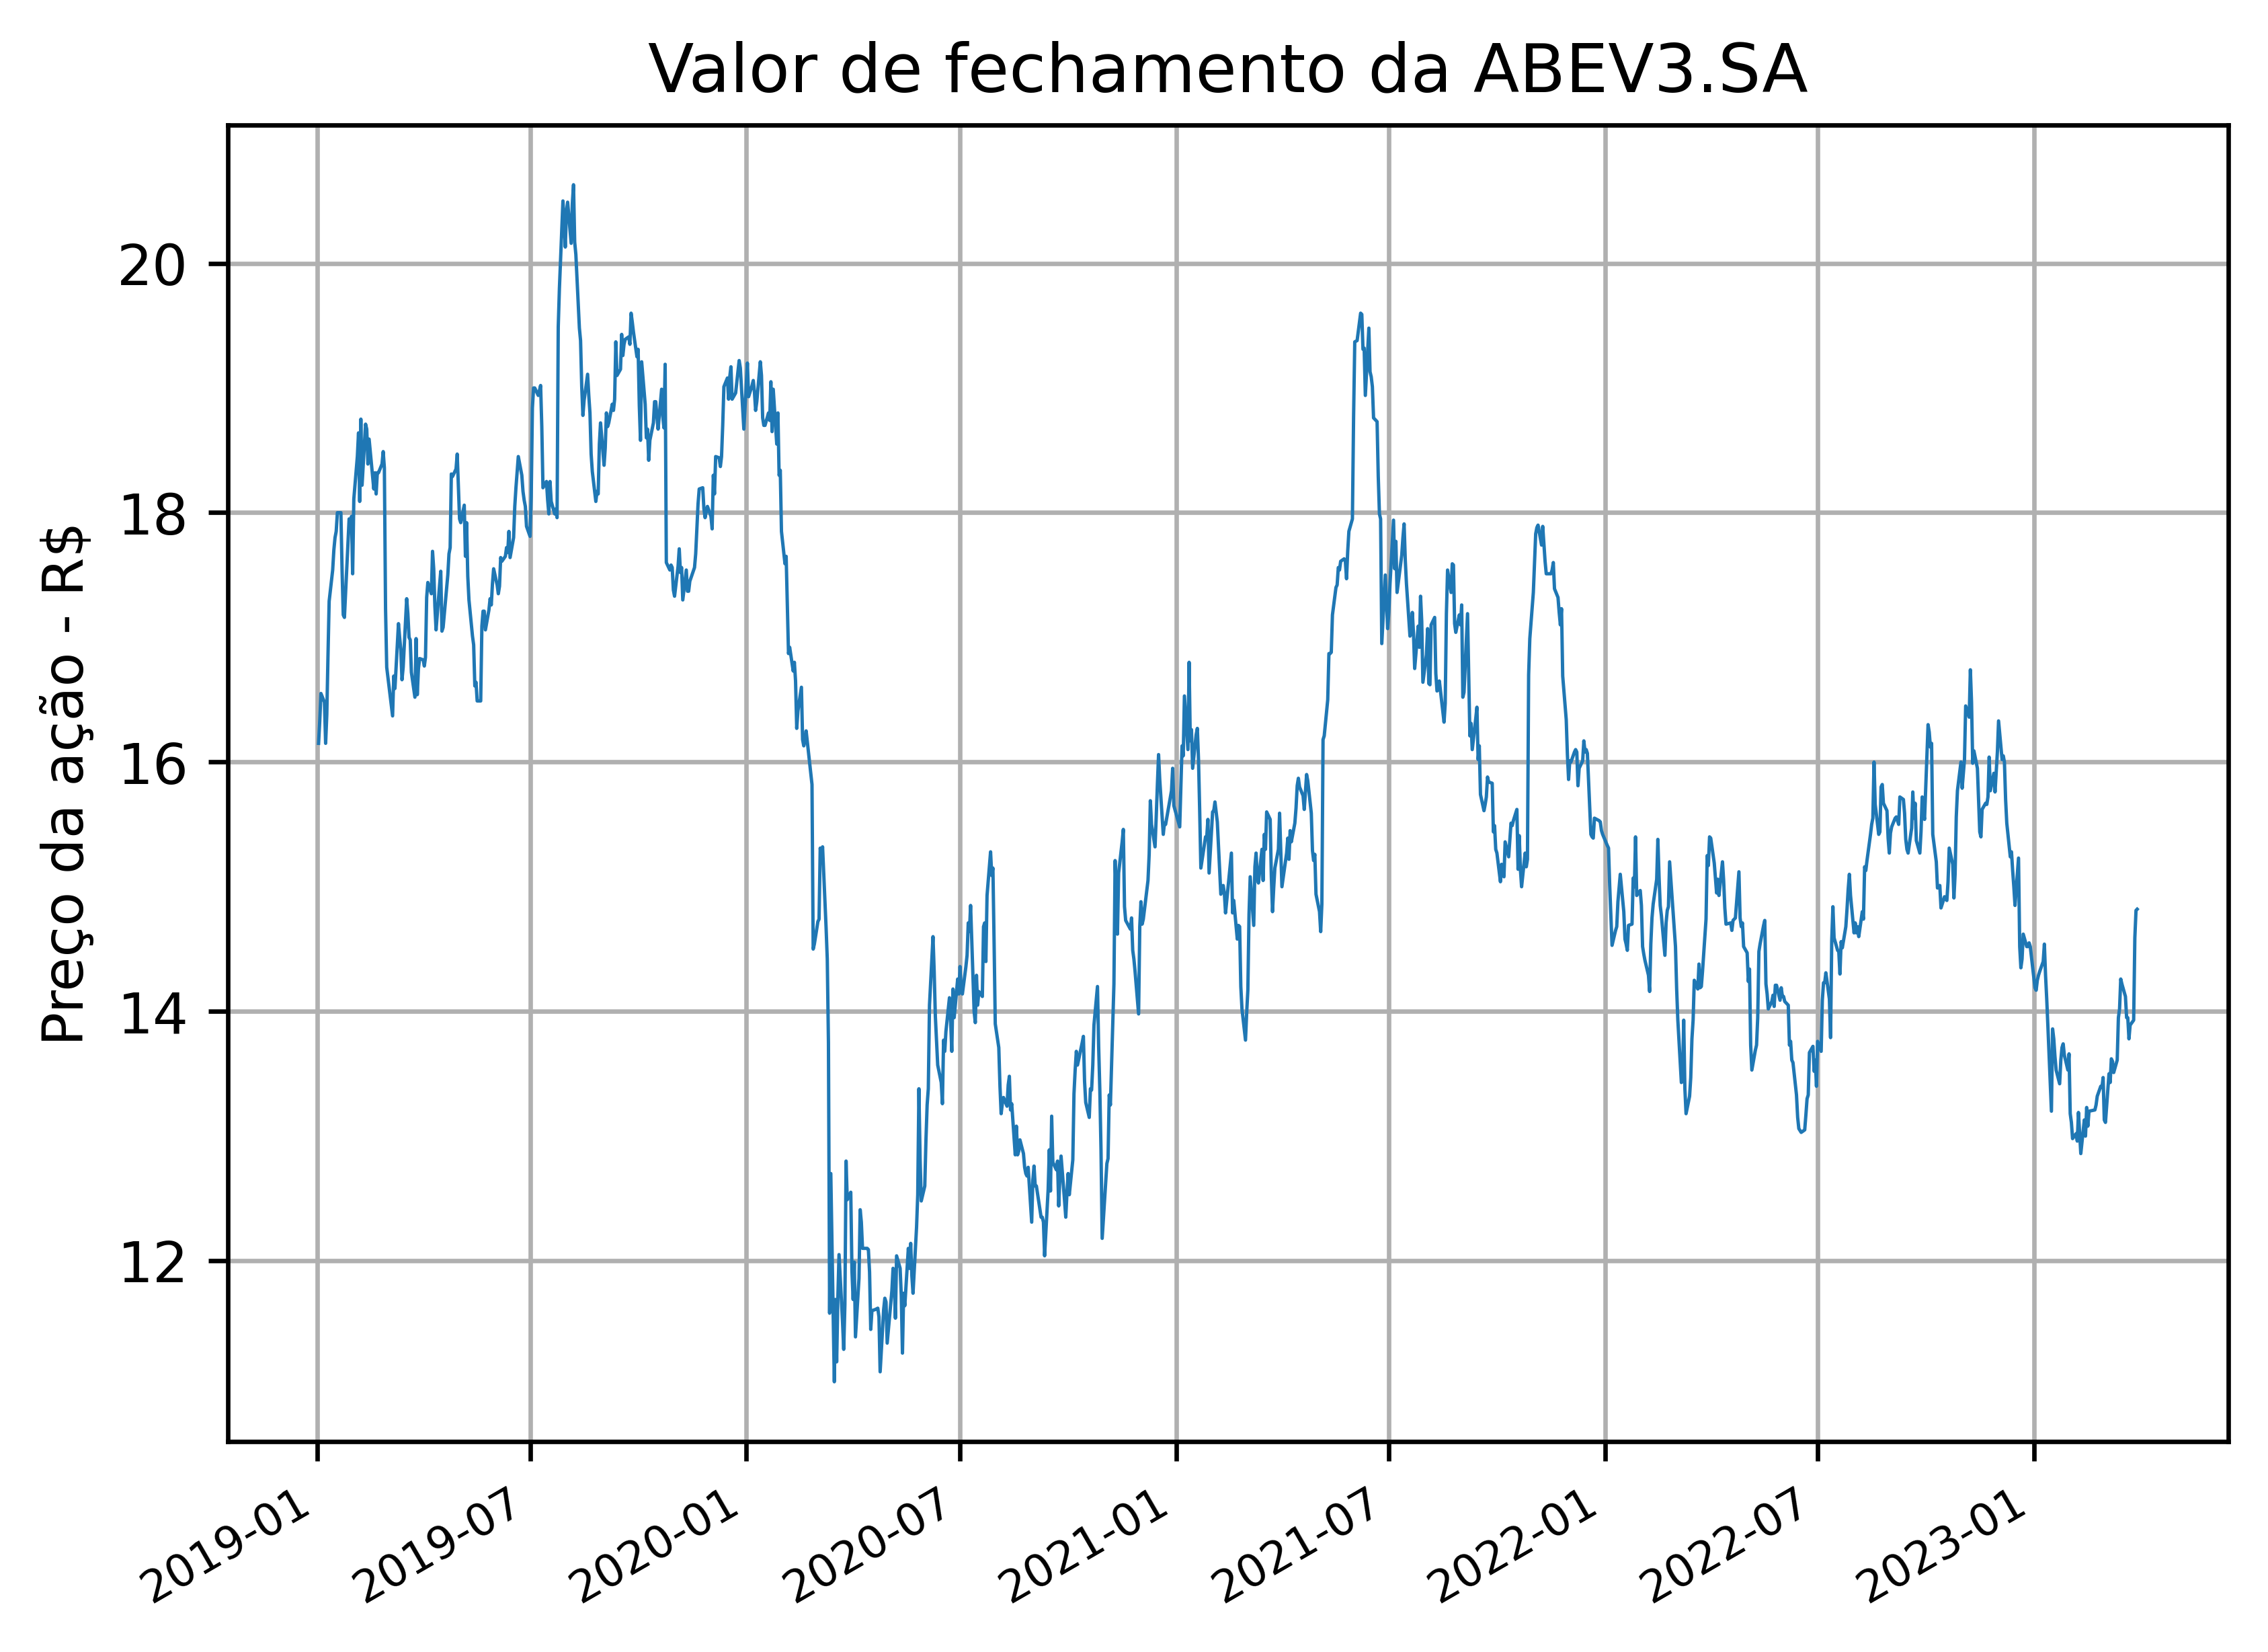

In [11]:
fig, ax = plt.subplots(dpi=600)

#Formatando os eixos
date_format = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

#Plotando o preço de fechamento em relação a data (intervalo de 1 dia)
ax.plot(dataset['Close'], lw=0.6)

#Adicionando títulos nos eixos
ax.set_ylabel('Preço da ação - R$')
ax.set_title('Valor de fechamento da ABEV3.SA')
ax.grid()

#Gráfico
plt.show()

In [12]:
#Análise simples, utilizando média móvel simples (MMS) de 9 dias e 30 dias

In [13]:
#Adicionando coluna MMS_9 e MMS_30
dataset['MMS_9'] = dataset['Close'].rolling(window=9, min_periods=1).mean()
dataset['MMS_30'] = dataset['Close'].rolling(window=30, min_periods=1).mean()

In [14]:
#Visualizando os últimos 5 valores do dataset
dataset.tail() 

,Open,High,Low,Close,Adj Close,Volume,MMS_9,MMS_30
Date,,,,,,,,
2023-03-24,13.84,14.02,13.75,13.89,13.89,27154200,14.015556,13.507000
2023-03-27,14.00,14.11,13.88,13.93,13.93,15709700,14.013333,13.537333
2023-03-28,13.95,15.03,13.90,14.59,14.59,121741000,14.076667,13.595000
2023-03-29,14.66,14.92,14.49,14.81,14.81,40734700,14.137778,13.651000
2023-03-30,15.00,15.05,14.75,14.82,14.82,24247000,14.204444,13.711667


In [15]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume,MMS_9,MMS_30
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1.055000e+03,1055.000000,1055.000000
mean,15.708190,15.931735,15.496711,15.706190,14.260852,2.615726e+07,15.713388,15.743953
std,2.035531,2.026508,2.043481,2.042831,1.637446,1.391946e+07,2.008209,1.930148
min,10.730000,11.210000,10.360000,11.030000,9.777991,4.149300e+06,11.534444,11.750667
25%,14.260000,14.450000,14.035000,14.230000,13.426379,1.725580e+07,14.293889,14.298833
50%,15.460000,15.680000,15.290000,15.460000,14.381416,2.296250e+07,15.507778,15.547333
75%,17.389999,17.615001,17.214999,17.405000,15.425414,3.132255e+07,17.415556,17.406167
max,20.410000,20.770000,20.330000,20.629999,17.919630,1.440625e+08,20.368889,19.308666


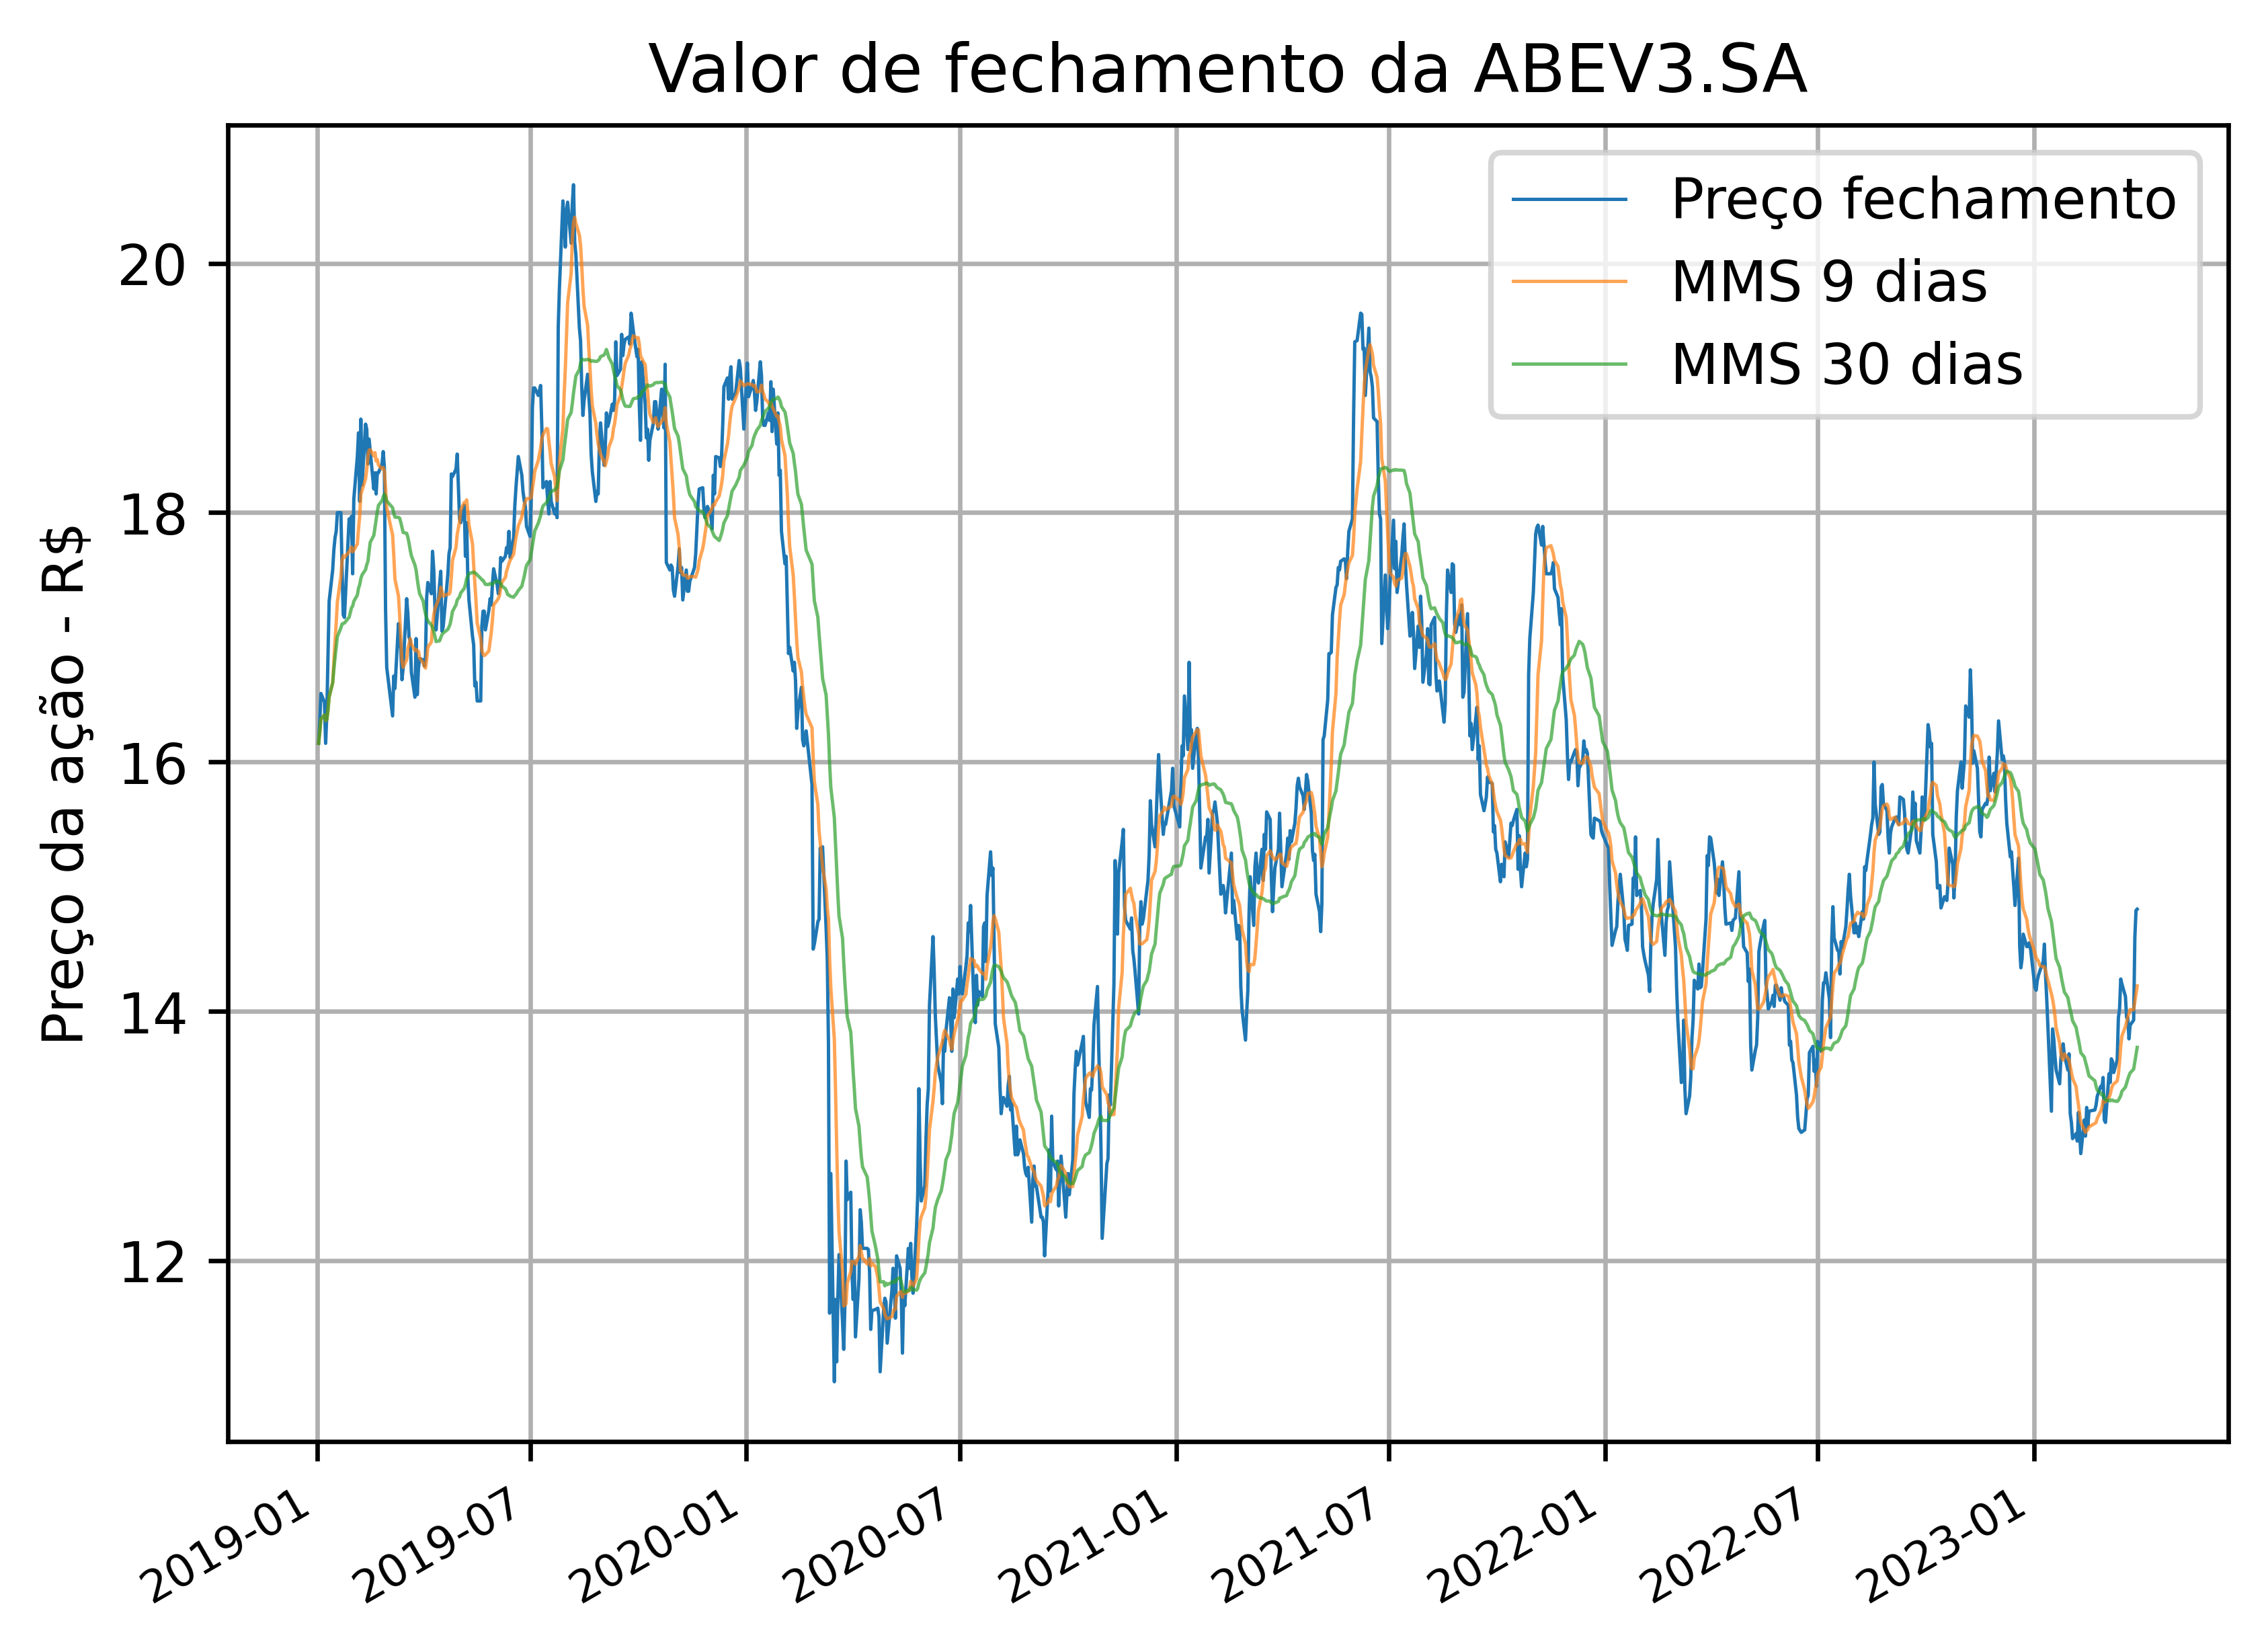

In [16]:
#Gráfico com as médias móveis
fig, ax = plt.subplots(dpi=600)
date_format = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(dataset['Close'], lw=0.6, label = 'Preço fechamento')
ax.plot(dataset['MMS_9'], lw=0.6, alpha=0.7, label='MMS 9 dias')
ax.plot(dataset['MMS_30'], lw=0.6, alpha=0.7, label='MMS 30 dias')

ax.set_ylabel('Preço da ação - R$')
ax.set_title('Valor de fechamento da ABEV3.SA')
ax.grid() 
ax.legend()

plt.show()

In [17]:
#Aplicando a rede neural LSTM

In [18]:
#Obtendo a coluna Close da base de treinamento e teste
training_set = dataset_train.iloc[:, 3:4].values 
real_stock_price = dataset_test.iloc[:, 3:4].values

In [19]:
#Normalizando
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [20]:
#Criando uma estrutura de dados com 60 etapas e 1 saída
X_train = []
y_train = []
for i in range(60, 737):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
#Remodelando
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
#Inicializando a rede RNN
regressor = Sequential()

In [23]:
#Adiocionando a primeira camada da LSTM
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [24]:
#Adicionando a segunda camada da LSTM
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [25]:
#Adicionando a terceira camada da LSTM
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

In [26]:
#Adicionando a quarta camada da LSTM
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [27]:
#Adicionando a camada de saída
regressor.add(Dense(units = 1))

#Compilando a RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#Ajustando a RNN ao conjunto de treinamento
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
22/22 [==============================] - 26s 196ms/step - loss: 0.0754
Epoch 2/100
22/22 [==============================] - 5s 208ms/step - loss: 0.0219
Epoch 3/100
22/22 [==============================] - 4s 202ms/step - loss: 0.0161
Epoch 4/100
22/22 [==============================] - 4s 199ms/step - loss: 0.0142
Epoch 5/100
22/22 [==============================] - 4s 200ms/step - loss: 0.0124
Epoch 6/100
22/22 [==============================] - 4s 191ms/step - loss: 0.0123
Epoch 7/100
22/22 [==============================] - 4s 188ms/step - loss: 0.0117
Epoch 8/100
22/22 [==============================] - 4s 182ms/step - loss: 0.0113
Epoch 9/100
22/22 [==============================] - 4s 190ms/step - loss: 0.0114
Epoch 10/100
22/22 [==============================] - 4s 190ms/step - loss: 0.0118
Epoch 11/100
22/22 [==============================] - 4s 182ms/step - loss: 0.0109
Epoch 12/100
22/22 [==============================] - 4s 198ms/step - loss: 0.0097
Epoch 13/100

In [28]:
#Resumo do modelo
print(regressor.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [29]:
#Realizando as previsões

In [30]:
dataset_total = dataset['Close']

In [31]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [32]:
len(inputs)

377

In [33]:
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

In [34]:
#O segundo número é o len(inputs)
for i in range(60, 377): 
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 [==============================] - 14s 55ms/step


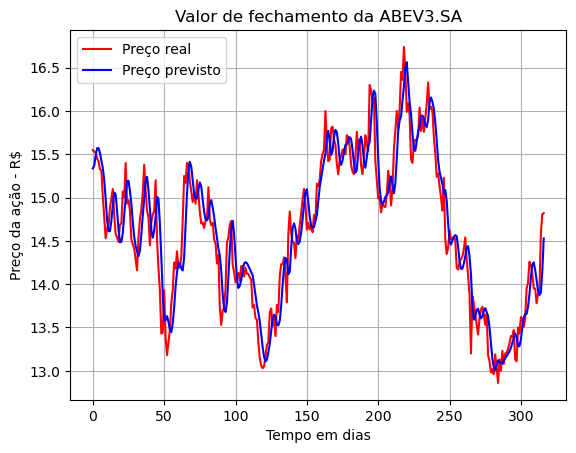

In [35]:
plt.plot(real_stock_price, color = 'red', label = 'Preço real')
plt.plot(predicted_stock_price, color = 'blue', label = 'Preço previsto')
plt.title('Valor de fechamento da ABEV3.SA')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço da ação - R$')
plt.legend()
plt.grid()
plt.show()

In [36]:
#Criando dataset único

#Criando a coluna data
dataset_test_graf = dataset_test.reset_index() #Criando um index

In [37]:
print(dataset_test_graf)

          Date   Open   High    Low  Close  Adj Close     Volume
0   2021-12-23  15.40  15.67  15.34  15.55  14.771684   10634700
1   2021-12-27  15.55  15.65  15.48  15.53  14.752684    8437200
2   2021-12-28  15.54  15.57  15.40  15.52  14.743185    7701300
3   2021-12-29  15.55  15.56  15.34  15.45  14.676688    8847300
4   2021-12-30  15.58  15.59  15.39  15.42  14.648190   11819300
..         ...    ...    ...    ...    ...        ...        ...
312 2023-03-24  13.84  14.02  13.75  13.89  13.890000   27154200
313 2023-03-27  14.00  14.11  13.88  13.93  13.930000   15709700
314 2023-03-28  13.95  15.03  13.90  14.59  14.590000  121741000
315 2023-03-29  14.66  14.92  14.49  14.81  14.810000   40734700
316 2023-03-30  15.00  15.05  14.75  14.82  14.820000   24247000

[317 rows x 7 columns]


In [38]:
real_stock_price_date = dataset_test_graf['Date'] #Criando um dataset com a coluna Date

In [39]:
print(real_stock_price_date)

0     2021-12-23
1     2021-12-27
2     2021-12-28
3     2021-12-29
4     2021-12-30
         ...    
312   2023-03-24
313   2023-03-27
314   2023-03-28
315   2023-03-29
316   2023-03-30
Name: Date, Length: 317, dtype: datetime64[ns]


In [40]:
real_stock_price_date = pd.DataFrame(real_stock_price_date, columns = ['Date']) #Incluindo a linha com o nome Date

In [41]:
real_stock_price_date.head()

,Date
0,2021-12-23
1,2021-12-27
2,2021-12-28
3,2021-12-29
4,2021-12-30


In [42]:
real_stock_price_close = dataset_test_graf['Close'] #Criando um dataset close real

In [43]:
print(real_stock_price_close)

0      15.55
1      15.53
2      15.52
3      15.45
4      15.42
       ...  
312    13.89
313    13.93
314    14.59
315    14.81
316    14.82
Name: Close, Length: 317, dtype: float64


In [44]:
real_stock_price_close_gra = pd.DataFrame(real_stock_price_close, columns = ['Close']) #Criando um dataset real

In [45]:
real_stock_price_close_gra.head()

,Close
0,15.55
1,15.53
2,15.52
3,15.45
4,15.42


In [46]:
predicted_stock_price_gra = pd.DataFrame(predicted_stock_price, columns = ['Predicted']) #Criando um dataset predicted

In [47]:
predicted_stock_price_gra.head()

,Predicted
0,15.337032
1,15.372163
2,15.486398
3,15.571176
4,15.571856


In [48]:
dataset_predicted=pd.concat([real_stock_price_date, real_stock_price_close_gra, predicted_stock_price_gra],axis=1,join='inner')

In [49]:
dataset_predicted.tail(5)

,Date,Close,Predicted
312,2023-03-24,13.89,13.926234
313,2023-03-27,13.93,13.875061
314,2023-03-28,14.59,13.902937
315,2023-03-29,14.81,14.149971
316,2023-03-30,14.82,14.529113


In [50]:
dataset_predicted = dataset_predicted.set_index('Date')

In [51]:
dataset_predicted.tail(5)

,Close,Predicted
Date,,
2023-03-24,13.89,13.926234
2023-03-27,13.93,13.875061
2023-03-28,14.59,13.902937
2023-03-29,14.81,14.149971
2023-03-30,14.82,14.529113


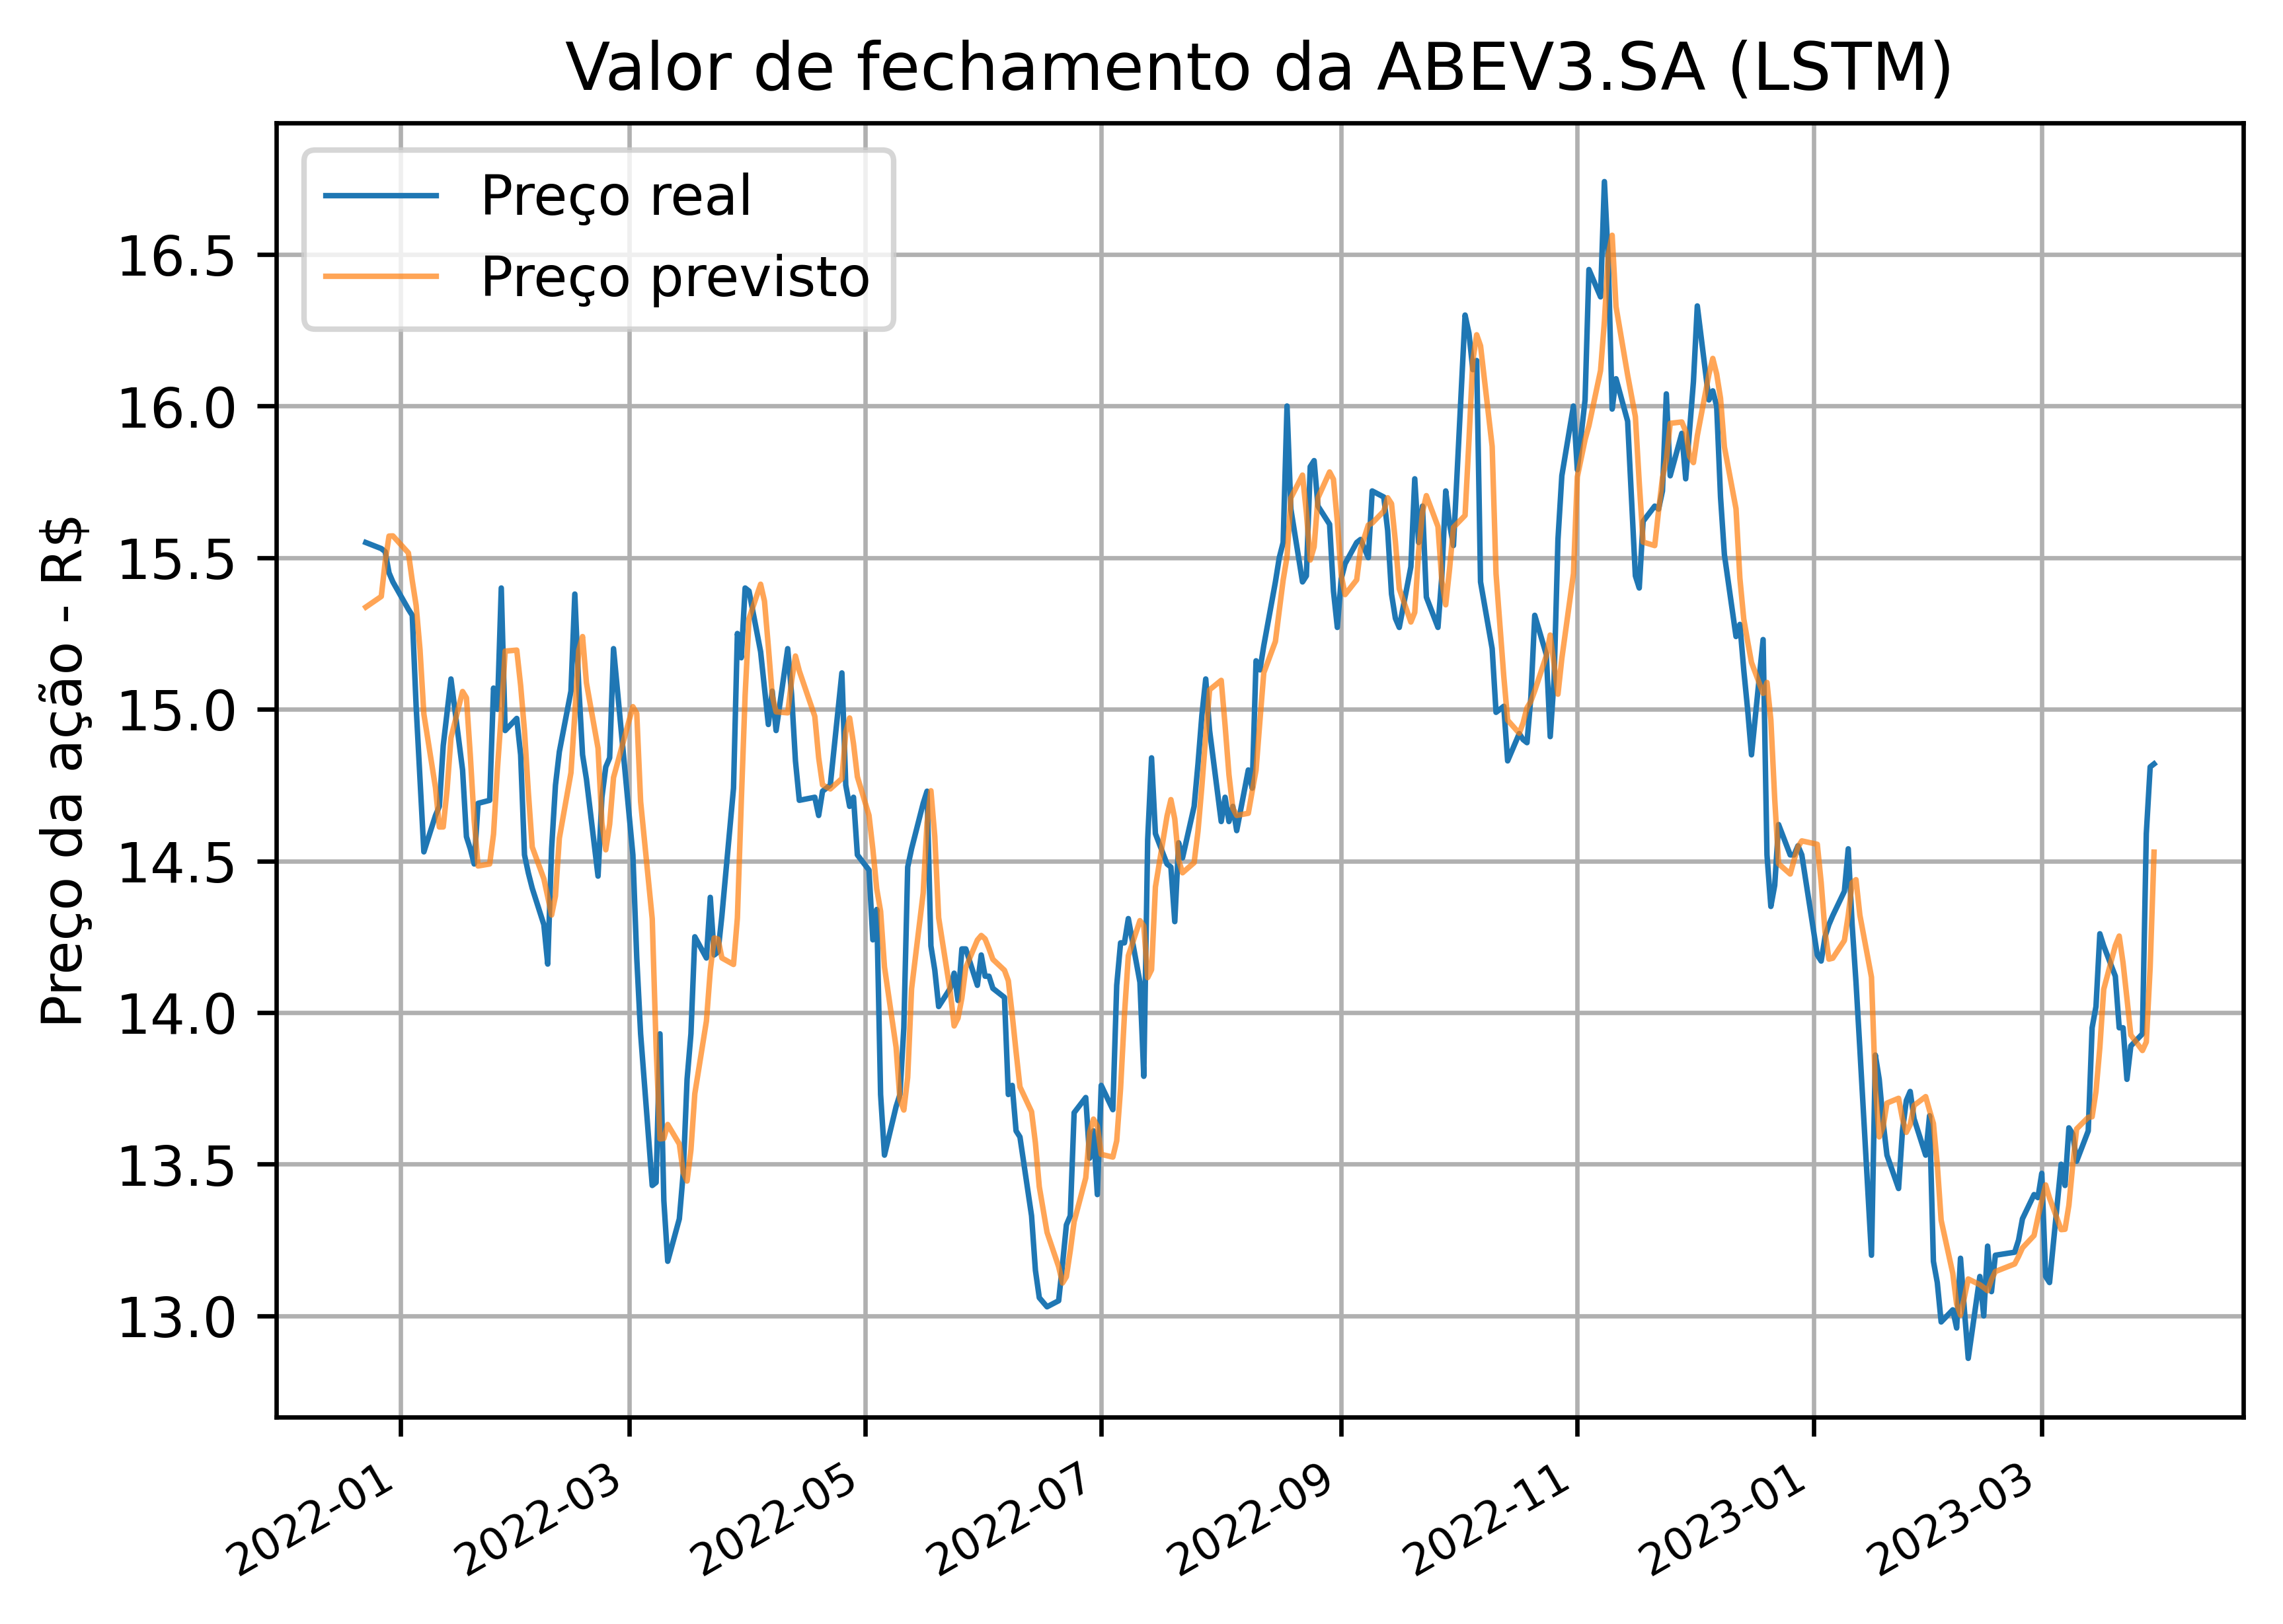

In [65]:
#Gráfico com as previsões
fig, ax = plt.subplots(dpi=600)
date_format = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_format)
ax.tick_params(axis='x', labelsize=8)
fig.autofmt_xdate()

ax.plot(dataset_predicted['Close'], lw=1, label = 'Preço real')
ax.plot(dataset_predicted['Predicted'], lw=1, alpha=0.7, label='Preço previsto')

ax.set_ylabel('Preço da ação - R$')
ax.set_title('Valor de fechamento da ABEV3.SA (LSTM)')
ax.grid() 
ax.legend()

plt.show()

In [53]:
#Métricas de avaliação

#Erro Médio Absoluto - MAE
MAE = mean_absolute_error(real_stock_price_close_gra, predicted_stock_price_gra)

In [54]:
#Erro Quadrático Médio - MSE
MSE = mean_squared_error(real_stock_price_close_gra, predicted_stock_price_gra, squared = True)

In [55]:
#Raiz quadrada do erro médio - RMSE
RMSE = mean_squared_error(real_stock_price_close_gra, predicted_stock_price_gra, squared = False)

In [56]:
#Média Percentual Absoluta do Erro - MAPE
MAPE = mean_absolute_percentage_error(real_stock_price_close_gra, predicted_stock_price_gra)

In [57]:
#Erro relativo

dataset_predicted['Error %'] = dataset_predicted.apply(lambda x: 100*(abs(x['Close']-x['Predicted'])/x['Close']), axis=1)

In [58]:
dataset_predicted.head()

,Close,Predicted,Error %
Date,,,
2021-12-23,15.55,15.337032,1.369568
2021-12-27,15.53,15.372163,1.016336
2021-12-28,15.52,15.486398,0.216512
2021-12-29,15.45,15.571176,0.784309
2021-12-30,15.42,15.571856,0.984802


In [59]:
Max = max(dataset_predicted['Error %'])

In [60]:
Min = min(dataset_predicted['Error %'])

In [61]:
print('Métricas de avaliação LSTM - ABEV3:')
print("MAE: {:.3f}".format(MAE))
print("MAPE: {:.3f}%".format(MAPE*100))
print("RMSE: {:.3f}".format(RMSE))
print("MSE: {:.3f}".format(MSE))
print('Máximo erro relativo = {:.3f}%'.format(Max))
print('Mínimo erro relativo = {:.3f}%'.format(Min))

Métricas de avaliação LSTM - ABEV3:
MAE: 0.235
MAPE: 1.614%
RMSE: 0.297
MSE: 0.088
Máximo erro relativo = 6.945%
Mínimo erro relativo = 0.007%


In [62]:
print('LSTM - ABEV3')
dataset_predicted.describe()

LSTM - ABEV3


,Close,Predicted,Error %
count,317.000000,317.000000,317.000000
mean,14.610946,14.637050,1.614013
std,0.859239,0.843005,1.249045
min,12.860000,13.002694,0.006929
25%,13.950000,13.992713,0.674755
50%,14.650000,14.650416,1.377596
75%,15.270000,15.298902,2.284347
max,16.740000,16.563089,6.945039


In [63]:
# Calcula os retornos logarítmicos usando o preço de fechamento 
returns = np.log(dataset_predicted['Close'] / dataset_predicted['Close'].shift(1))
volatility = returns.std() * np.sqrt(252) 
sharpe_ratio = ((returns.mean()*252) - 0.1375) / volatility #Selic 13,75%
print("Sharpe Ratio - ABEV3: {:.2f}".format(sharpe_ratio))

Sharpe Ratio - ABEV3: -0.70


In [64]:
# Calcula os retornos logarítmicos usando o preço de fechamento 
returns = np.log(dataset_predicted['Predicted'] / dataset_predicted['Predicted'].shift(1))
volatility = returns.std() * np.sqrt(252) 
sharpe_ratio = ((returns.mean()*252) - 0.1375) / volatility #Selic 13,75%
print("Sharpe Ratio - ABEV3: {:.2f}".format(sharpe_ratio))

Sharpe Ratio - ABEV3: -1.18


In [ ]:
#Fim